# Coursework 1: Gaussian processes
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/cw/coursework1.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/). This version adapted by Damon Wischik._

In this assignment you will use Gaussian process modelling.
This coursework uses the Python package [`sklearn.gaussian_process`](http://scikit-learn.org/stable/modules/gaussian_process.html) which is the rough equivalent of the [GPML](http://www.gaussianprocess.org/gpml/code/matlab/doc/) package for MATLAB. See the appendix at the end of this document for a walkthrough.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. Complete listings are
unnecessary. The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two.

In [1]:
# Standard imports for scientific and engineering work in Python:
import numpy as np                      # MATLAB-style matrix and vector manipulation
import matplotlib.pyplot as plt         # MATLAB-style plotting
import matplotlib                       # for more control over plotting
import scipy.io                         # some useful data input-output routines
import sklearn.gaussian_process as gp   # Gaussian process modeling
import requests                         # for retrieving data over the web
import io                               # also used for importing data
import pandas   
import random
# data-science-style dataset manipulation
# Configure matplotlib to show its output right in the notebook
%matplotlib inline

## Question (a)

Load data from `https://teachingfiles.blob.core.windows.net/probml/cw1a.mat`. Consider a Gaussian process with a squared exponential covariance function,
```
ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ),
```
and minimize the negative log marginal likelihood starting with hyperparameters `λ=np.exp(-1)`, `ν=1`, `σ=1`. Show the 95% predictive error bars. Comment on the predictive error bars and the optimized hyperparameters.

In [2]:
# To import a .mat file from a URL:
r = requests.get('https://teachingfiles.blob.core.windows.net/probml/cw1a.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']

In [3]:
print("x has shape {}".format(x.shape))
print("y has shape {}".format(y.shape))

x has shape (75, 1)
y has shape (75, 1)


In [4]:
print("x values are between {} and {}".format(min(x), max(x)))

x values are between [-2.89661989] and [2.5093152]


### Definining the Gaussian Process

In [5]:
λ = np.exp(-1)
ν = 1
σ = 1

kernel = ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ)

gpr = gp.GaussianProcessRegressor(kernel=kernel)

### Optimizing the Hyperparameters

In [6]:
print("The initial hyperparameters are:")
print("ν = {}".format(np.exp(gpr.kernel.theta[0])))
print("λ = {}".format(np.exp(gpr.kernel.theta[1])))
print("σ = {}".format(np.exp(gpr.kernel.theta[2])))

gpr = gpr.fit(x, y)

print("The optimized hyperparameters are:")
print("ν = {}".format(np.exp(gpr.kernel_.theta[0])))
print("λ = {}".format(np.exp(gpr.kernel_.theta[1])))
print("σ = {}".format(np.exp(gpr.kernel_.theta[2])))

The initial hyperparameters are:
ν = 1.0
λ = 0.36787944117144233
σ = 1.0
The optimized hyperparameters are:
ν = 0.8045925347987415
λ = 0.128226382830948
σ = 0.01388341481616946


Let's try to understand what these hyperparameters tell us.

First of all, the estimate of σ represents the noise that is present in the data. In this case σ = 0.0138.

λ represents the length scale of the squared-exponential kernel. A high value of λ forces points which are far away to be closely correlated, whereas a very small value of λ means that even points which are very close can result in very different values. In summary, it controls how smooth the function is. λ = 0.128 is not very large so our function turns out to be relatively bumpy.

ν just represents how much weight to give to the squared-exponential kernel compared to the white noise kernel.

### Making Predictions

In [7]:
def plot_predictions(model, x, y):
    # New values of x where we want to make a prediction
    newx = np.linspace(-3, 3, 61)
    μ,σ = model.predict(newx[..., np.newaxis], return_std=True)

    # Plot the output.
    # squeeze() is a numpy function that turns column vectors into simple 1d vectors.
    with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
        plt.fill_between(newx, μ.squeeze()-2*σ, μ.squeeze()+2*σ, alpha=.2)
        plt.plot(newx, μ.squeeze())
        plt.scatter(x, y, color='black')
        plt.title(model.kernel_)
        plt.text(0.7, 1.9, "Log Marginal Likelihood: {0:1f}".format(model.log_marginal_likelihood()), fontsize=12)
    plt.show()

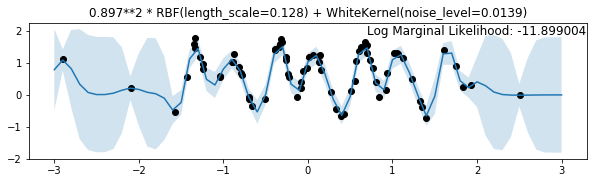

In [8]:
plot_predictions(gpr, x, y)

The 95% predictive error bars can be calculated by subtracting and adding two times the standard deviation from the mean result.
As we can see, the error bar is wider as the edges of the chart, where we have fewer data points, and so we are more uncertaint about what the generating function looks like.

## Question (b)

Show that by initializing the hyperparameters differently, you can ﬁnd a different local optimum for the hyperparameters. Try a range of values. Show the fit. Explain what is going on. Which fit is best, and why? 

In [9]:
λ = 2
ν = 1.1
σ = 1.1

kernel = ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ)

gpr = gp.GaussianProcessRegressor(kernel=kernel)

print("The initial hyperparameters are:")
print("ν = {}".format(np.exp(gpr.kernel.theta[0])))
print("λ = {}".format(np.exp(gpr.kernel.theta[1])))
print("σ = {}".format(np.exp(gpr.kernel.theta[2])))

gpr = gpr.fit(x, y)

print("The optimized hyperparameters are:")
print("ν = {}".format(np.exp(gpr.kernel_.theta[0])))
print("λ = {}".format(np.exp(gpr.kernel_.theta[1])))
print("σ = {}".format(np.exp(gpr.kernel_.theta[2])))

The initial hyperparameters are:
ν = 1.2100000000000002
λ = 2.0
σ = 1.1
The optimized hyperparameters are:
ν = 0.4844544399379191
λ = 8.048376018769641
σ = 0.4396678317629532


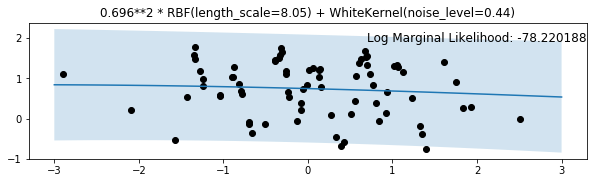

In [10]:
plot_predictions(gpr, x, y)

With initial parameters ν = 1.1, λ = 2.0, σ = 1.1 we converge to a different local minimum, which is a much worse fit for the data compared to the previous one, given that it is basically a straight line and does not explain any of the data. This optimized kernel has a very big length scale.

In [11]:
λ = random.random() * 10
ν = random.random() * 10
σ = random.random() * 10

kernel = ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ)

gpr = gp.GaussianProcessRegressor(kernel=kernel)
gpr = gpr.fit(x, y)

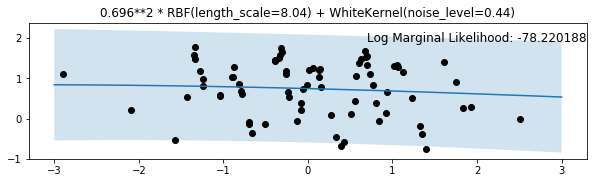

In [12]:
plot_predictions(gpr, x, y)

This different local minimum has instead a very small length scale.

## Question (c)

Train instead a GP with a periodic covariance function, using [`gp.kernels.ExpSineSquared`](http://scikit-learn.org/stable/modules/gaussian_process.html#exp-sine-squared-kernel). Show the fit. Comment on the
behaviour of the error-bars, compared to your fit from (a). Do you think the data generating mechanism
was really periodic? Why, why not?

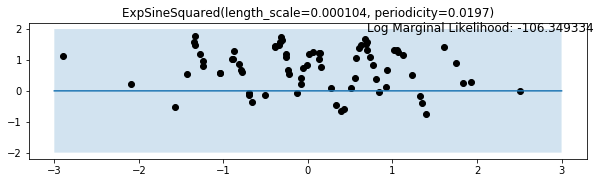

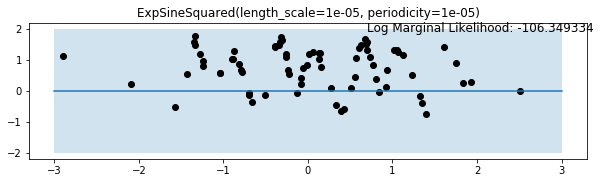

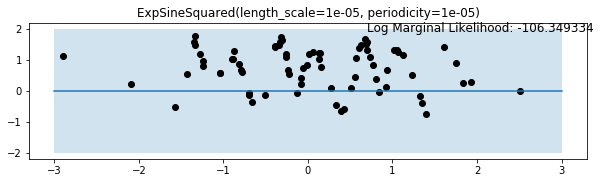

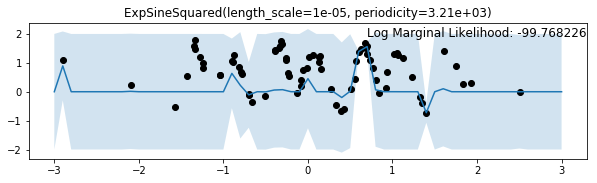

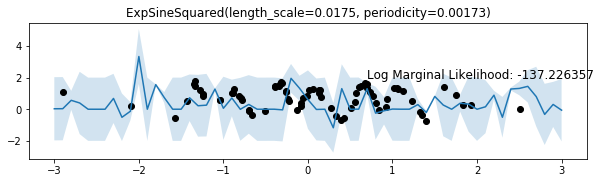

In [13]:
for i in range(5):
    λ = random.random() 
    p = random.random()

    kernel = gp.kernels.ExpSineSquared(length_scale=λ, periodicity=p)
    gpr = gp.GaussianProcessRegressor(kernel=kernel)
    gpr = gpr.fit(x, y)
    plot_predictions(gpr, x, y)

All the fits don't look great. Even the third one, which is the best, has a log marginal likelhood which is worse than the straight lines we obtained in part b), and much worse than the nice fit we obtained in part a).

## Question (d)

Generate 200 noise-free data points at `x = np.linspace(-5,5,200)` from a Gaussian process with the following
covariance function: 
```
1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) 
    * gp.kernels.RBF(length_scale=np.exp(2)))
```
Don’t add noise to the function values, i.e. don't add `gp.kernels.WhiteKernel()` to the kernel.
Using `GaussianProcessRegressor.sample_y()`, plot some sample functions. Explain their behaviour.

_The choice of kernel dictates what output are likely. By looking at sample functions, 
you gain experience of the expressive power of Gaussian process models. Ultimately, you should be able to look at a scatterplot and
know straight away what type of kernel would be a good fit._

In [14]:
x = np.linspace(-5,5,200).reshape(-1, 1)

kernel = 1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) * gp.kernels.RBF(length_scale=np.exp(2))
gpr = gp.GaussianProcessRegressor(kernel=kernel)

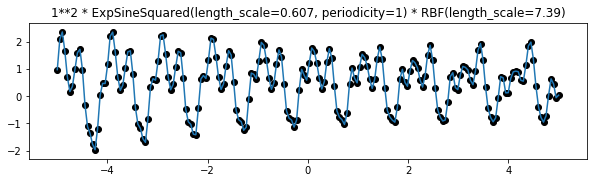

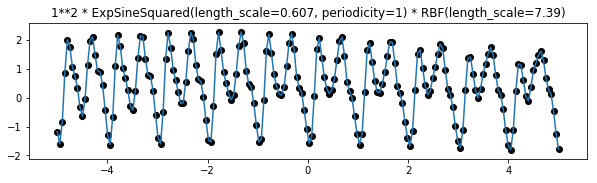

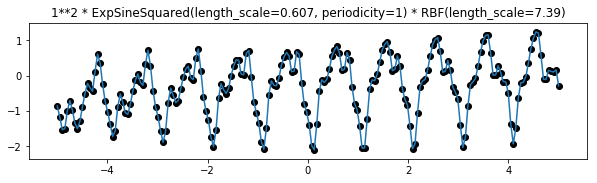

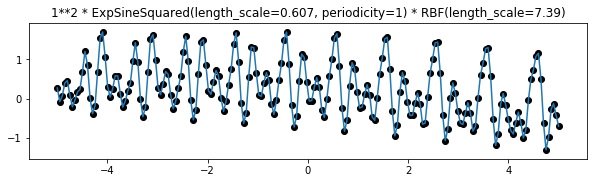

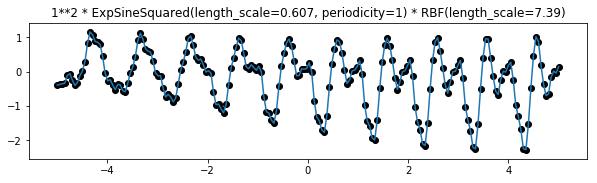

In [15]:
for i in range(5):
    y = gpr.sample_y(x, random_state=None).reshape(200, 1)

    with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
        plt.plot(x, y)
        plt.scatter(x, y, color='black')
        plt.title(gpr.kernel)
    plt.show()

These functions are drawn from the prior distribution over functions specified by the given kernel. The kernel is the product of a periodic kernel and the squared-exponential kernel. The resulting kernel is similar to a periodic one, but points lose correlation as they get further apart.

## Question (e)

Load `https://teachingfiles.blob.core.windows.net/probml/cw1e.mat`. This data has two-dimensional input and scalar output. Visualise the data, e.g. using the code snippets in the appendix.
Consider two different Gaussian process models of the data, one using covariance function
`RBF(length_scale=[l1,l2])`
and the other using the sum of two such `RBF` terms. (Make sure to break symmetry, e.g. by choosing the initial hyperparameters randomly.)

Compare the two models. How do the data fits compare? How do the marginal likelihoods compare? What is your interpretation? Which of the two is better?

> When `length_scale` is a list, the `RBF` kernel uses separate length-scale parameters for each dimension of the input space. In GPML it is known as 'Squared Exponential with Automatic Relevance Determination', `covSEard`. It is a useful tool to learn which inputs are important for predictions: if length-scales are short, inputs are very important, and when they grow very long (compared to the spread of the data), the corresponding inputs will be largely ignored.

In [16]:
r = requests.get('https://teachingfiles.blob.core.windows.net/probml/cw1e.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']

### Visualize Data

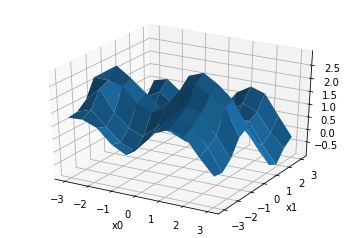

In [17]:
from mpl_toolkits.mplot3d import axes3d   # import a library to allow 3d plots

# Reshape the data to be in array form
X = x[:,0].reshape((11,11))
Y = x[:,1].reshape((11,11))
Z = y.reshape((11,11))

# Optionally: use `%matplotlib notebook` to make the plots interactive.
# Get axes for a 3d plot, and then plot the surface
axes = plt.figure().gca(projection='3d')
axes.plot_surface(X, Y, Z)
axes.set_xlabel('x0')
axes.set_ylabel('x1')
plt.show()

### First Gaussian process

In [18]:
best_log_likelihood = -20000

for i in range(50):
    λ1 = random.random() 
    λ2 = random.random() 

    kernel = gp.kernels.RBF(length_scale=[λ1, λ2])
    gpr = gp.GaussianProcessRegressor(kernel=kernel)
    gpr.fit(x, y)
    
    best_log_likelihood = max(best_log_likelihood, gpr.log_marginal_likelihood())

print("Best log likelihood for the first gaussian process is: {}".format(best_log_likelihood))

Best log likelihood for the first gaussian process is: -75.73546214052642


In [19]:
best_log_likelihood

-75.73546214052642

### Second Gaussian process

In [20]:
best_log_likelihood = -20000

for i in range(50):
    λ1 = random.random()
    λ2 = random.random() 
    λ3 = random.random()
    λ4 = random.random() 

    kernel = gp.kernels.RBF(length_scale=[λ1, λ2]) + gp.kernels.RBF(length_scale=[λ3, λ4])
    gpr = gp.GaussianProcessRegressor(kernel=kernel)
    gpr.fit(x, y)

best_log_likelihood = max(best_log_likelihood, gpr.log_marginal_likelihood())

print("Best log likelihood for the second gaussian process is: {}".format(best_log_likelihood))

Best log likelihood for the second gaussian process is: -65.90322739556376


After 50 tries with different initial hyperparameters for the two version of the Gaussian Process, version 1 obtains a best log likelihood of -75.73 whereas version 2 obtains a best log likelihood of -65.90. Therefore, version 2 obtains a better fit.

## Question (f)

Load `https://teachingfiles.blob.core.windows.net/probml/twoseries.csv`. This data consists of two time series, where $t$ is time, $k$ is the index of the series, and $y$ is the output. 
The data has two-dimensional input, but the second dimension is categorical rather than numerical, so it doesn't make sense to use the RBF kernel. Instead,
consider the model
$$
Y_{t,k} = Z_t + E_k + \operatorname{Normal}(0,\sigma^2)
$$
where $Z_t$ is a shared underlying RBF Gaussian process, and $E_1$ and $E_2$ are independent $\operatorname{Normal}(0,\rho^2)$ offsets, giving
$$
\operatorname{Cov}(Y_{t,k}, Y_{t',k'}) = \nu^2 \exp \Bigl( -\frac{(t-t')^2}{2\ell^2}\Bigr) + \rho^2 \delta_{k k'} + \sigma^2 \delta_{t t'}\delta_{k k'}.
$$
Implement a kernel for this model, fit it, and plot your predicted values for the two time series.

In [21]:
twoseries = pandas.read_csv('https://teachingfiles.blob.core.windows.net/probml/twoseries.csv')
t,k,y = twoseries['t'].values, twoseries['k'].values, twoseries['y'].values

In [22]:
t[:10]

array([-3.        , -2.96984925, -2.90954774, -2.87939698, -2.75879397,
       -2.72864322, -2.66834171, -2.6080402 , -2.57788945, -2.45728643])

In [23]:
k[:10]

array([2, 1, 1, 2, 2, 2, 1, 1, 2, 2])

In [24]:
x = np.stack([t, k], axis=1)
x[:10]

array([[-3.        ,  2.        ],
       [-2.96984925,  1.        ],
       [-2.90954774,  1.        ],
       [-2.87939698,  2.        ],
       [-2.75879397,  2.        ],
       [-2.72864322,  2.        ],
       [-2.66834171,  1.        ],
       [-2.6080402 ,  1.        ],
       [-2.57788945,  2.        ],
       [-2.45728643,  2.        ]])

In [25]:
y[:10]

array([ 1.22019743, -1.51683505, -2.01393591,  1.03403916, -0.96291076,
       -1.62120919, -3.75923822, -2.95730042, -0.30828219,  1.86034692])

In [26]:
x_1 = [v for i, v in enumerate(t) if k[i] == 1]
y_1 = [v for i, v in enumerate(y) if k[i] == 1]

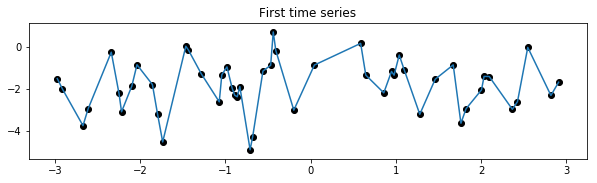

In [27]:
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.plot(x_1, y_1)
    plt.scatter(x_1, y_1, color='black')
    plt.title("First time series")
plt.show()

In [28]:
x_2 = [v for i, v in enumerate(t) if k[i] == 2]
y_2 = [v for i, v in enumerate(y) if k[i] == 2]

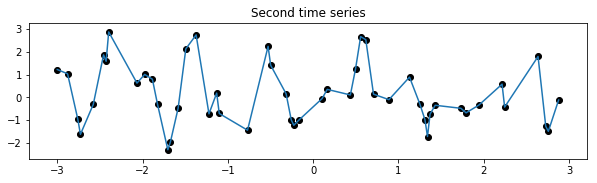

In [29]:
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.plot(x_2, y_2)
    plt.scatter(x_2, y_2, color='black')
    plt.title("Second time series")
plt.show()

### Custom Kernel

In [100]:
from scipy.spatial.distance import cdist  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])

class MyKernel(gp.kernels.Kernel):
    def __init__(self, length_scale=np.exp(-1), length_scale_bounds=(1e-5, 1e5), nu=1.0, nu_bounds=(1e-5, 1e5), rho=1.0, rho_bounds=(1e-5, 1e5), sigma=1.0, sigma_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
        self.nu = nu
        self.nu_bounds = nu_bounds
        self.rho = rho
        self.rho_bounds = rho_bounds
        self.sigma = sigma
        self.sigma_bounds = sigma_bounds

    @property
    def hyperparameter_length_scale(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("length_scale", 'numeric', self.length_scale_bounds, 1)
            
    @property
    def hyperparameter_nu(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("nu", 'numeric', self.nu_bounds, 1)
    
    @property
    def hyperparameter_rho(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("rho", 'numeric', self.rho_bounds, 1)
    
    @property
    def hyperparameter_sigma(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("sigma", 'numeric', self.sigma_bounds, 1)

    def is_stationary(self):
        return True
    
    def diag(self, X):
        return np.diagonal(self(X, X))

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y) if Y is not None else X
        
        λ = np.squeeze(self.length_scale).astype(float)
        ν = np.squeeze(self.nu).astype(float)
        ρ = np.squeeze(self.rho).astype(float)
        σ = np.squeeze(self.sigma).astype(float)
        
        if λ.ndim != 0:
            raise ValueError("λ must be a number")
        if ν.ndim != 0:
            raise ValueError("ν must be a number")
        if ρ.ndim != 0:
            raise ValueError("ρ must be a number")
        if σ.ndim != 0:
            raise ValueError("σ must be a number")
        
        t_x = X[:,0]
        k_x = X[:,1]
        
        t_y = Y[:,0]
        k_y = Y[:,1]
        
        n_x = len(X)
        n_y = len(Y)
        
        # K1[i][j] = ν ** 2 * np.exp(-((t_x[i] - t_y[j]) ** 2) / (2 * (λ ** 2)))
        K1 = (ν ** 2) * np.exp(-0.5 * cdist(t_x.reshape(-1, 1), t_y.reshape(-1, 1), metric='sqeuclidean') / λ**2)
        
        K2 = np.zeros((n_x, n_y))
        for i in range(n_x):
            for j in range(n_y):
                K2[i][j] = ρ ** 2 if k_x[i] == k_y[j] else 0
        
        K3 = np.zeros((n_x, n_y))
        for i in range(n_x):
            for j in range(n_y):
                K3[i][j] = σ ** 2 if k_x[i] == k_y[j] and t_x[i] == t_y[j] else 0
                
        K = K1 + K2 + K3
        
        if not eval_gradient:
            return K

        # The gradient is with respect to log-transformed parameters.
        # I.e. if length_scale=exp(x), then eval_gradient should return d/dx.
        # If there are multiple hyperparameters, return an array with one
        # column for each non-fixed hyperparameter, sorted alphabetically
        # by hyperparameter name.
        if self.hyperparameter_length_scale.fixed or self.hyperparameter_rho.fixed or self.hyperparameter_sigma.fixed:
            K_gradient = np.empty((n_x, n_y, 0))
        else:
            # λ_gradient[i][j] = K1[i][j] * ((t_x[i] - t_y[j]) ** 2) / (λ ** 2)
            λ_gradient = K1 * cdist(t_x.reshape(-1, 1), t_y.reshape(-1, 1), metric='sqeuclidean') / λ**2
    
            # ν_gradient[i][j] = K1[i][j] * 2 * (ν ** 2)
            ν_gradient = 2 * (ν ** 2) * K1 
                    
            ρ_gradient = np.zeros((n_x, n_y))
            for i in range(n_x):
                for j in range(n_y):
                    ρ_gradient[i][j] = 2 * (ρ ** 2) if k_x[i] == k_y[j] else 0
            
            σ_gradient = np.zeros((n_x, n_y))
            for i in range(n_x):
                for j in range(n_y):
                    σ_gradient[i][j] = 2 * (σ ** 2) if k_x[i] == k_y[j] and t_x[i] == t_y[j] else 0
            
            
            K_gradient = np.stack([λ_gradient, ν_gradient, ρ_gradient, σ_gradient], axis=-1)
            
        return K, K_gradient

    def __repr__(self):
        return f"RBF(length_scale={self.length_scale:.3g})"

## Use Kernel

In [101]:
kernel = MyKernel() + gp.kernels.WhiteKernel()

In [102]:
gpr = gp.GaussianProcessRegressor(kernel=kernel)
gpr.fit(x, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=0.368) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [103]:
# New values of x where we want to make a prediction
newt = np.concatenate((np.linspace(-3, 3, 61), np.linspace(-3, 3, 61)))
newk = np.concatenate((np.full((61,), 1), np.full((61,), 2)))
newx = np.stack([newt, newk], axis=1)

### Plot Fit for First Time Series

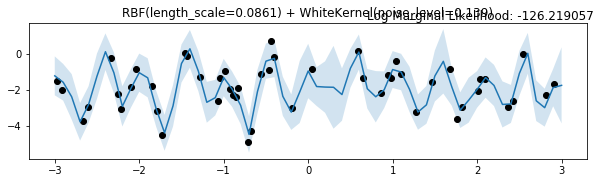

In [104]:
μ,σ = gpr.predict(newx, return_std=True)
newt1 = newt[newk == 1]
newk1 = newk[newk == 1]
μ1 = μ[newk == 1]
σ1 = σ[newk == 1]

# Plot the output.
# squeeze() is a numpy function that turns column vectors into simple 1d vectors.
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.fill_between(newt1, μ1.squeeze()-2*σ1, μ1.squeeze()+2*σ1, alpha=.2)
    plt.plot(newt1, μ1.squeeze())
    plt.scatter(x_1, y_1, color='black')
    plt.title(gpr.kernel_)
    plt.text(0.7, 1.9, "Log Marginal Likelihood: {0:1f}".format(gpr.log_marginal_likelihood()), fontsize=12)
plt.show()

### Plot Fit for Second Time Series

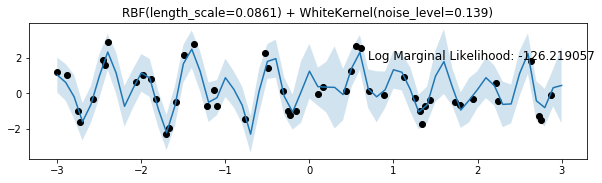

In [105]:
μ,σ = gpr.predict(newx, return_std=True)
newt2 = newt[newk == 2]
newk2 = newk[newk == 2]
μ2 = μ[newk == 2]
σ2 = σ[newk == 2]

# Plot the output.
# squeeze() is a numpy function that turns column vectors into simple 1d vectors.
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.fill_between(newt2, μ2.squeeze()-2*σ2, μ2.squeeze()+2*σ2, alpha=.2)
    plt.plot(newt2, μ2.squeeze())
    plt.scatter(x_2, y_2, color='black')
    plt.title(gpr.kernel_)
    plt.text(0.7, 1.9, "Log Marginal Likelihood: {0:1f}".format(gpr.log_marginal_likelihood()), fontsize=12)
plt.show()

The fit looks extremely good in both cases!

<div style="height: 15em"></div>

# Appendix

## Gaussian processes in Python

Here is a simple example of how to use `sklearn.gaussian_process`. For full details, see the [documentation](http://scikit-learn.org/stable/modules/gaussian_process.html).

Let's consider a simple Gaussian process model: a prior on the space of Gaussian processes, with mean 0, and with covariance function
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr)
$$
(this function is called `RBF` in `sklearn.gaussian_process` and `covSEiso` in GPML). Suppose that the data model is  
$$
p(y\:|\:x,f) \sim
\operatorname{Normal}\bigl(f(x), \sigma^2 I\bigr)
$$
where $x$ and $y$ are vectors and $f(x)$ means $(f(x_1),\dots,f(x_n))$. In this model, $\nu$, $\ell$ and $\sigma$ are hyperparameters. Another way to write out this entire model is with a single covariance function,
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr) + \sigma^2 \delta_{x x'}.
$$

In the `gaussian_process` package, a Gaussian process model is specified by a _kernel_ object. (Kernel is another name for covariance function.) The package has a [library of kernels](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels), each implemented as a Python class, and we can create composite kernels by adding together and multiplying kernel objects.

In [ ]:
l = np.exp(-1)
ν = 0.5
σ = 1
kernel1 = ν**2 * gp.kernels.RBF(length_scale=l) + gp.kernels.WhiteKernel(noise_level=σ)
kernel1

To extract parameters from a kernel, use `get_params()`. You can also use `set_params` to set the parameters for a kernel.

In [ ]:
kernel1.get_params()

Machine learning functions are implemented via the class `GaussianProcessRegressor`, which is initialized with a kernel object. It has methods for learning hyperparameters and making predictions. We can access a model's kernel with `GaussianProcessRegressor.kernel`.

In [ ]:
model1 = gp.GaussianProcessRegressor(kernel=kernel1)
model1.kernel

To learn hyperparameters, use `GaussianProcessRegressor.fit(x,y)`. It requires the parameters to be arrays with one row per observation. In the example below we start with one-dimensional input and output, so we have to reshape them to be column vectors. We can access the fitted kernel, and thence the fitted parameters, with `model.kernel_`.

In [ ]:
# Training data
x = np.array([0.57650, 0.43504, 0.76607, -0.78369, -1.27129, -0.66034, 1.18100, 
              0.25929, 0.50898, -0.73703, 0.83023, 1.60078, -0.34655, -0.68073, 
              -1.21480, -0.55955, -1.28229, 0.85388, 0.73265, -0.75330])
y = np.array([ 0.96948, 1.08384, 0.62050, -0.65940, 0.54944, -0.88911, -0.37886,
              0.77166, 0.97753, -0.75901, 0.76003, -1.13327, -0.74600, -0.99293,
              0.60169, -0.98088, 0.55333, 0.60247, 0.99501, -0.83345])

model1.fit(x[..., np.newaxis], y[..., np.newaxis])
model1.kernel_

To make predictions with a fitted model, call `GaussianProcessRegressor.predict(x)`. As before, `x` should be a column vector.

In [ ]:
# New values of x where we want to make a prediction
newx = np.linspace(-3, 3, 61)
μ,σ = model1.predict(newx[..., np.newaxis], return_std=True)

# Plot the output.
# squeeze() is a numpy function that turns column vectors into simple 1d vectors.
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.fill_between(newx, μ.squeeze()-2*σ, μ.squeeze()+2*σ, alpha=.2)
    plt.plot(newx, μ.squeeze())
    plt.scatter(x, y, color='black')
    plt.title(model1.kernel_)
plt.show()

## Custom kernels

If there is no standard kernel that captures the covariance function we want, it's easy to implement a custom kernel. 
Below is a reimplementation of the RBF kernel, which has covariance function
$$
k(x, x') = \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr).
$$
The main method is `__call__`, which computes a covariance matrix, 
and is invoked by
```
k = MyRBFKernel(length_scale=2.718)
x = np.array([1,2,4])[:, np.newaxis]
y = np.array([1.5,3])[:, np.newaxis]
k(x,y)     # returns a matrix m_{i,j} = kernel(x_i, y_j)
```
The `__init__` constructor should accept arguments for each hyperparameter,
and there should be `hyperparameter_X` properties that describe each hyperparameter.
The simple implementation below requires $x\in\mathbb{R}$, but the [source code for the built-in RBF kernel](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/gaussian_process/kernels.py) allows multidimensional features $x\in\mathbb{R}^d$ with anisotropic length-scale $\ell\in\mathbb{R}^d$.
It is also more efficient.

In [ ]:
from scipy.spatial.distance import cdist  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])

class MyRBFKernel(gp.kernels.Kernel):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    @property
    def hyperparameter_length_scale(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("length_scale", 'numeric', self.length_scale_bounds, 1)

    def is_stationary(self):
        return True
    
    def diag(self, X):
        return np.diagonal(self(X, X))

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y) if Y is not None else X
        if X.ndim != 2 or Y.ndim != 2 or X.shape[1] != 1 or Y.shape[1] != 1:
            raise ValueError("Features must be scalars")
        length_scale = np.squeeze(self.length_scale).astype(float)
        if length_scale.ndim != 0:
            raise ValueError("Length scale must be a number")
        
        K = np.exp(-0.5 * cdist(X, Y, metric='sqeuclidean') / length_scale**2)
        
        if not eval_gradient:
            return K

        # The gradient is with respect to log-transformed parameters.
        # I.e. if length_scale=exp(x), then eval_gradient should return d/dx.
        # If there are multiple hyperparameters, return an array with one
        # column for each non-fixed hyperparameter, sorted alphabetically
        # by hyperparameter name.
        if self.hyperparameter_length_scale.fixed:
            K_gradient = np.empty((len(X), len(Y), 0))
        else:
            K_gradient = K * cdist(X, Y, metric='sqeuclidean') / length_scale**2
        print(K_gradient[:, :, np.newaxis].shape)
        return K, K_gradient[:, :, np.newaxis]

    def __repr__(self):
        return f"RBF(length_scale={self.length_scale:.3g})"

In [ ]:
kernel = MyRBFKernel()
gpr = gp.GaussianProcessRegressor(kernel=kernel)
gpr.fit(x, y)

## Plotting a function of two variables

Here are some ways we might plot the data from part (e).

In [ ]:
from mpl_toolkits.mplot3d import axes3d   # import a library to allow 3d plots

# Reshape the data to be in array form
X = x[:,0].reshape((11,11))
Y = x[:,1].reshape((11,11))
Z = y.reshape((11,11))

# Optionally: use `%matplotlib notebook` to make the plots interactive.
# Get axes for a 3d plot, and then plot the surface
axes = plt.figure().gca(projection='3d')
axes.plot_surface(X, Y, Z)
axes.set_xlabel('x0')
axes.set_ylabel('x1')
plt.show()

In [ ]:
# A heatmap
plt.imshow(y.reshape((11,11)), extent=np.array([-3,3,-3,3])*12/11, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('x0')
plt.ylabel('x1')
plt.colorbar()
plt.show()